In [4]:
!wget https://raw.githubusercontent.com/UtkarshRaj130/Advanced_Soybean_Agricultural_Dataset_Analysis/refs/heads/main/Dataset/3_duplicates_removed.csv -O 3_duplicates_removed.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# 1. Load Dataset + Preprocessing

In [6]:
# Load data
df = pd.read_csv("3_one_hot_encoded.csv").drop_duplicates()

# Define target and all features
selected_features = ["Sugars (Su)", "Weight of 300 Seeds (W3S)",
                     "Seed Yield per Unit Area (SYUA)", "Number of Seeds per Pod (NSP)",
                     "Protein Percentage (PPE)", "Protein Content (PCO)", "Number of Pods (NP)"]

all_features = df.columns.difference(["Parameters", "Random "])  # drop ID/meta if needed

# Clean
df = df.dropna(subset=selected_features)
df = df.reset_index(drop=True)

# Feature Sets
X_all = df[all_features].copy()
X_selected = df[selected_features].copy()

# Scale both
scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

scaler_sel = StandardScaler()
X_sel_scaled = scaler_sel.fit_transform(X_selected)


 # 2. SHAP Scoring Function

In [7]:
def compute_shap_cluster_score(X_input, cluster_labels, model_output='probability'):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_input, cluster_labels, stratify=cluster_labels, random_state=42)
    model.fit(X_train, y_train)

    explainer = shap.Explainer(model, X_input, model_output=model_output)
    shap_values = explainer(X_input, check_additivity=False)

    n_clusters = len(np.unique(cluster_labels))
    cluster_avg_shap = {}

    for cluster_id in range(n_clusters):
        indices = np.where(cluster_labels == cluster_id)[0]
        if len(indices) == 0:
            continue
        shap_cluster = shap_values.values[indices, :, cluster_id]
        cluster_shap_mean = np.abs(shap_cluster).mean(axis=0)
        cluster_avg_shap[cluster_id] = cluster_shap_mean.mean()

    if len(cluster_avg_shap) == 0:
        return {}, 0.0, 0.0

    overall_avg = np.mean(list(cluster_avg_shap.values()))
    overall_std = np.std(list(cluster_avg_shap.values()))

    return cluster_avg_shap, overall_avg, overall_std


# 3.  Fit Cluster Models on Both Feature Sets

In [8]:
from collections import OrderedDict

k_values = [2, 5, 6, 7]
cluster_models = OrderedDict()

# -- KMeans
for k in k_values:
    cluster_models[f"KMeans_k={k}_all"] = KMeans(n_clusters=k, random_state=42).fit_predict(X_all_scaled)
    cluster_models[f"KMeans_k={k}_sel"] = KMeans(n_clusters=k, random_state=42).fit_predict(X_sel_scaled)

# -- KMedoids
for k in k_values:
    cluster_models[f"KMedoids_k={k}_all"] = KMedoids(n_clusters=k, random_state=42).fit_predict(X_all_scaled)
    cluster_models[f"KMedoids_k={k}_sel"] = KMedoids(n_clusters=k, random_state=42).fit_predict(X_sel_scaled)

# -- GMM (only 6, 7)
for k in [6, 7]:
    cluster_models[f"GMM_k={k}_all"] = GaussianMixture(n_components=k, random_state=42).fit(X_all_scaled).predict(X_all_scaled)
    cluster_models[f"GMM_k={k}_sel"] = GaussianMixture(n_components=k, random_state=42).fit(X_sel_scaled).predict(X_sel_scaled)

  File "c:\Users\utkar\.conda\envs\AI_Lab\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


#  4.  Evaluate All Clustering Models

In [9]:
results = {
    "Model": [],
    "Feature_Set": [],
    "Average SHAP": [],
    "SHAP Std Dev": [],
    "Stability Score (Avg/Std)": []
}

# Run SHAP evaluations
for name, labels in cluster_models.items():
    if "_all" in name:
        X_used = X_all.copy()
        feat_set = "All Features"
    else:
        X_used = X_selected.copy()
        feat_set = "Selected Features"

    # 🛠 Force dtype to float64 cleanly
    X_used = pd.DataFrame(X_used.values.astype(np.float64), columns=X_used.columns)

    print(f"{name}")
    _, avg, std = compute_shap_cluster_score(X_used, labels)
    score = avg / std if std > 0 else 0

    results["Model"].append(name.replace("_all", "").replace("_sel", ""))
    results["Feature_Set"].append(feat_set)
    results["Average SHAP"].append(avg)
    results["SHAP Std Dev"].append(std)
    results["Stability Score (Avg/Std)"].append(score)


KMeans_k=2_all
KMeans_k=2_sel
KMeans_k=5_all
KMeans_k=5_sel
KMeans_k=6_all
KMeans_k=6_sel
KMeans_k=7_all
KMeans_k=7_sel
KMedoids_k=2_all
KMedoids_k=2_sel
KMedoids_k=5_all
KMedoids_k=5_sel
KMedoids_k=6_all
KMedoids_k=6_sel
KMedoids_k=7_all
KMedoids_k=7_sel
GMM_k=6_all
GMM_k=6_sel
GMM_k=7_all
GMM_k=7_sel


# 5. Visualize the Results - Side-by-Side Comparison Plot

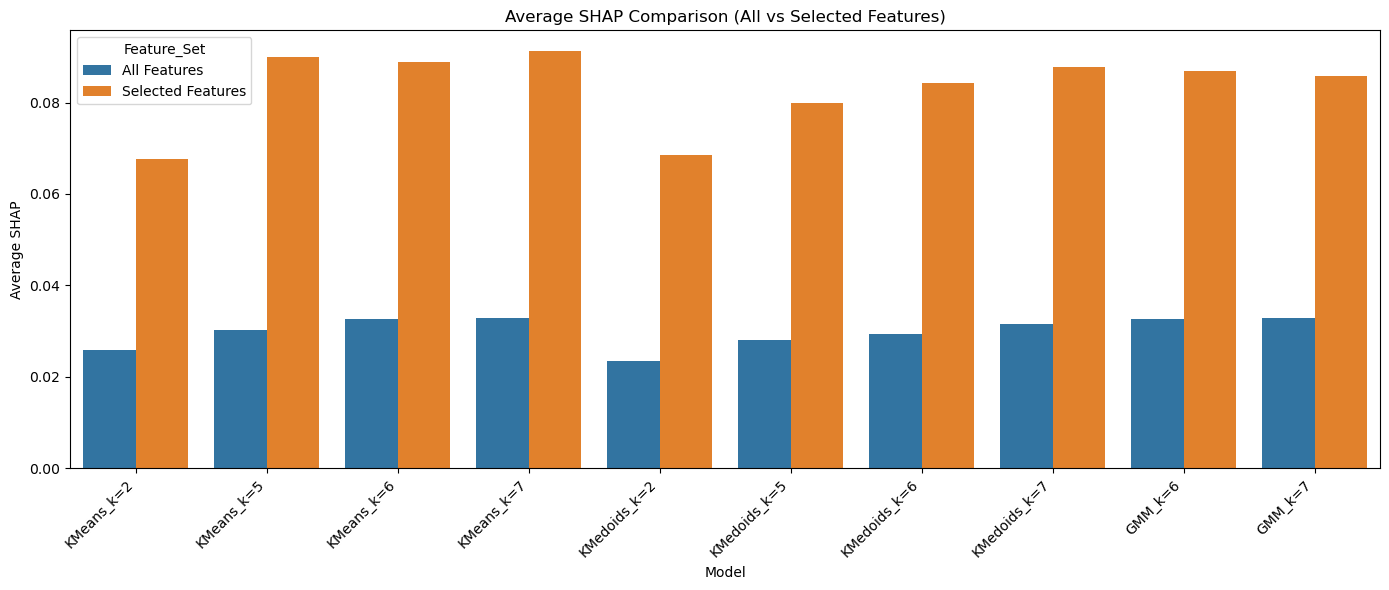

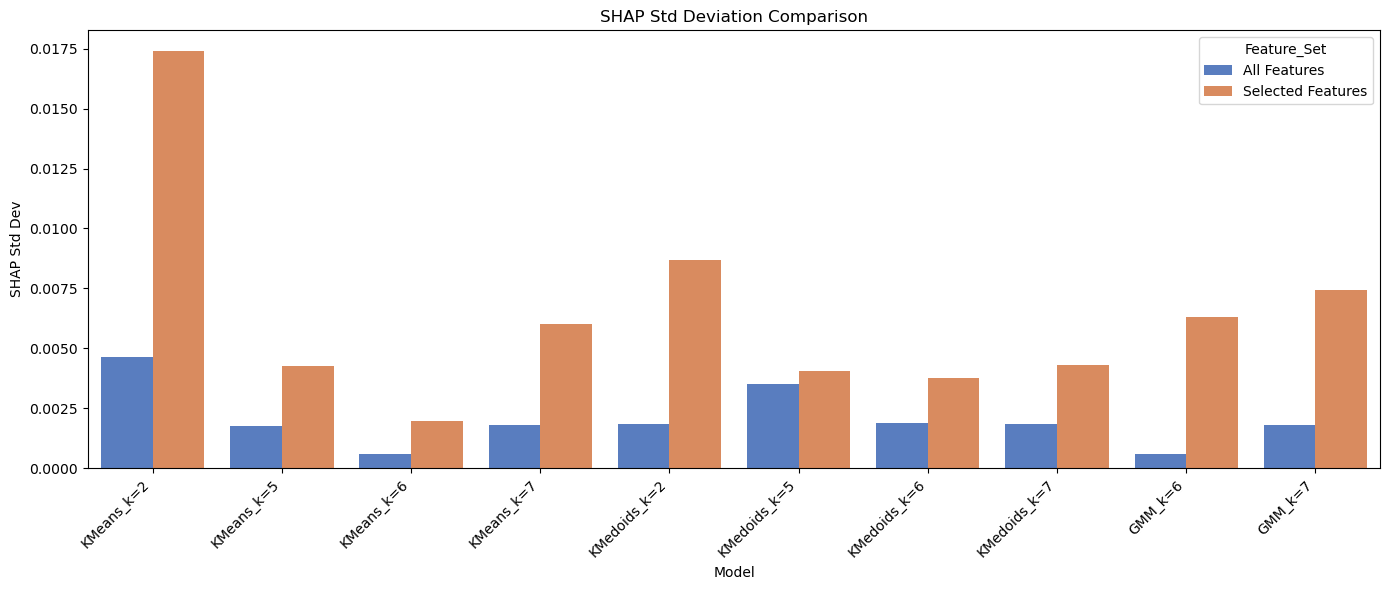

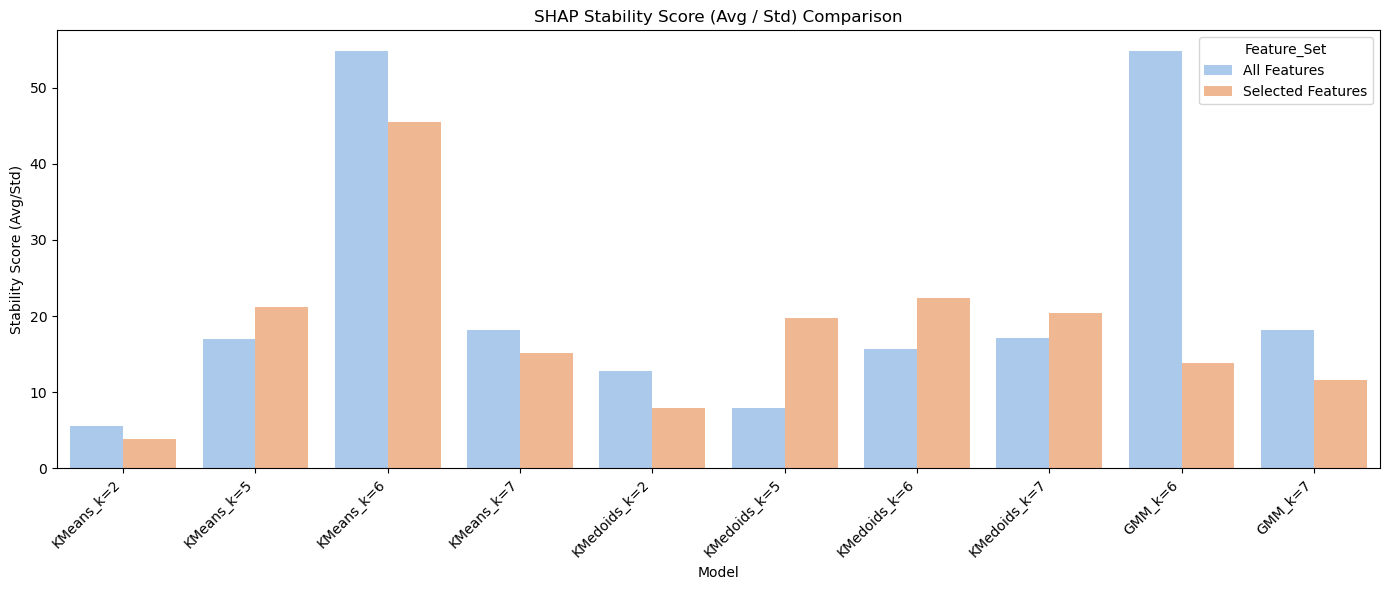

In [10]:
# Convert to DataFrame
df_results = pd.DataFrame(results)

# Grouped barplot for SHAP Avg
plt.figure(figsize=(14, 6))
sns.barplot(data=df_results, x="Model", y="Average SHAP", hue="Feature_Set")
plt.title("Average SHAP Comparison (All vs Selected Features)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Std Dev
plt.figure(figsize=(14, 6))
sns.barplot(data=df_results, x="Model", y="SHAP Std Dev", hue="Feature_Set", palette="muted")
plt.title("SHAP Std Deviation Comparison")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Stability Score
plt.figure(figsize=(14, 6))
sns.barplot(data=df_results, x="Model", y="Stability Score (Avg/Std)", hue="Feature_Set", palette="pastel")
plt.title("SHAP Stability Score (Avg / Std) Comparison")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

 (Optional) Export Results

In [11]:
df_results.to_csv("shap_clustering_comparison.csv", index=False)

#  6. Label Clusters Based on Production Features

In [12]:

def assign_production_labels(df_base, cluster_labels, cluster_name, selected_features, shap_weights=None):
    df_labeled = df_base.copy()
    df_labeled["Cluster"] = cluster_labels

    # --- Step 1: Cluster-wise Means
    cluster_means = df_labeled.groupby("Cluster")[selected_features].mean()

    # --- Step 2: Compute score
    if shap_weights:
        cluster_means["Score"] = sum(cluster_means[feat] * shap_weights[feat] for feat in selected_features)
    else:
        cluster_means["Score"] = cluster_means[selected_features].sum(axis=1)

    # --- Step 3: Rank clusters by score
    cluster_ranking = cluster_means["Score"].sort_values().reset_index()
    cluster_ranking["Production_Label"] = cluster_ranking.index  # 0 (low) → 5 (high)

    # --- Step 4: Map back to DataFrame
    cluster_map = dict(zip(cluster_ranking["Cluster"], cluster_ranking["Production_Label"]))
    label_col = f"Prod_Label_{cluster_name}"
    df_labeled[label_col] = df_labeled["Cluster"].map(cluster_map)

    return df_labeled, label_col, cluster_means


# 7. Assign Labels to All Models (k=6 only)

In [13]:
# Optional SHAP weights from earlier analysis (can adjust)
shap_weights = {
    "Seed Yield per Unit Area (SYUA)": 1,
    "Number of Pods (NP)": 1,
    "Protein Content (PCO)": 1,
    "Weight of 300 Seeds (W3S)": 1,
    "Protein Percentage (PPE)": 1,
    "Number of Seeds per Pod (NSP)": 1,
    "Sugars (Su)": 1
}

# Store output
production_label_columns = []
labeled_frames = []

for name, labels in cluster_models.items():
    # if "k=6" not in name:
    #     continue  # only label 6-cluster models

    # Decide which data to use
    X_used = X_all if "_all" in name else X_selected
    df_used = df.copy()

    # Apply label assignment
    df_prod, label_col, cluster_means = assign_production_labels(
        df_used, labels, cluster_name=name, selected_features=selected_features, shap_weights=shap_weights
    )

    production_label_columns.append(label_col)
    labeled_frames.append((name, df_prod, label_col))


# 8. Visualize: SYUA Boxplot per Production Label


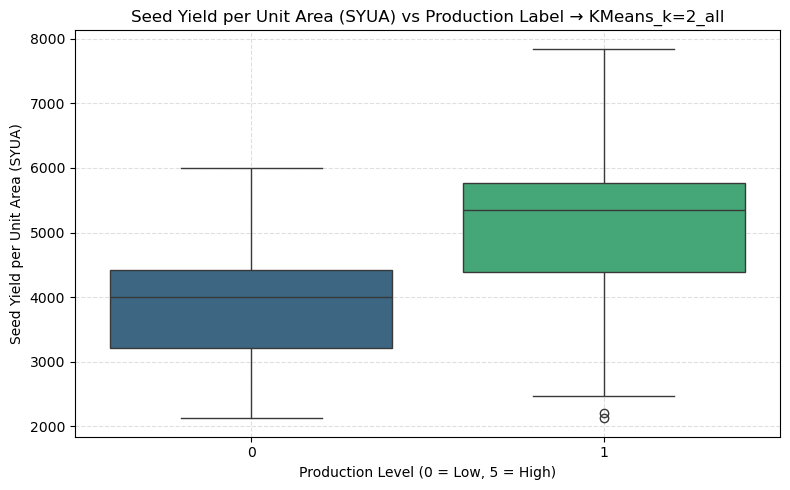

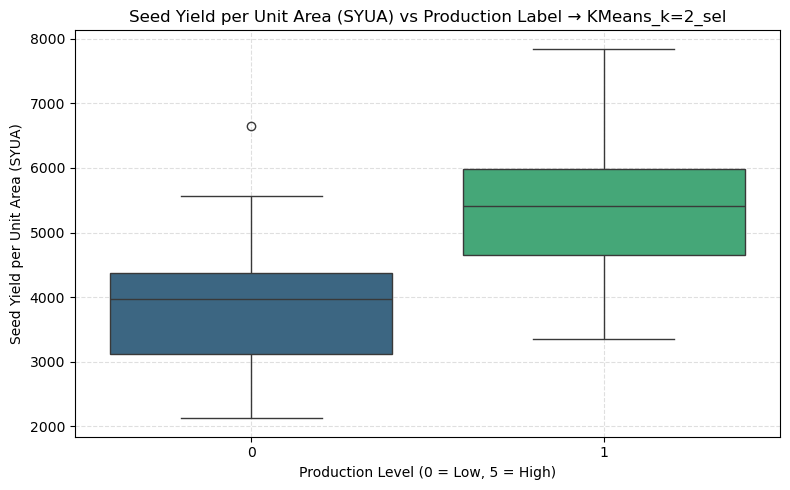

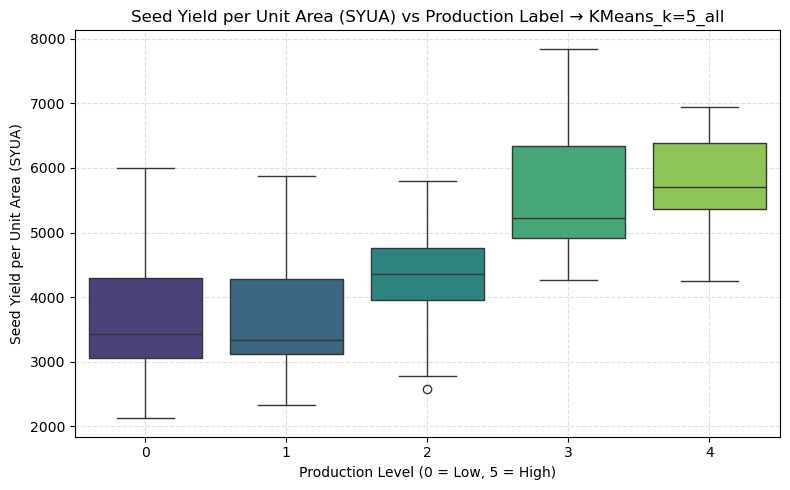

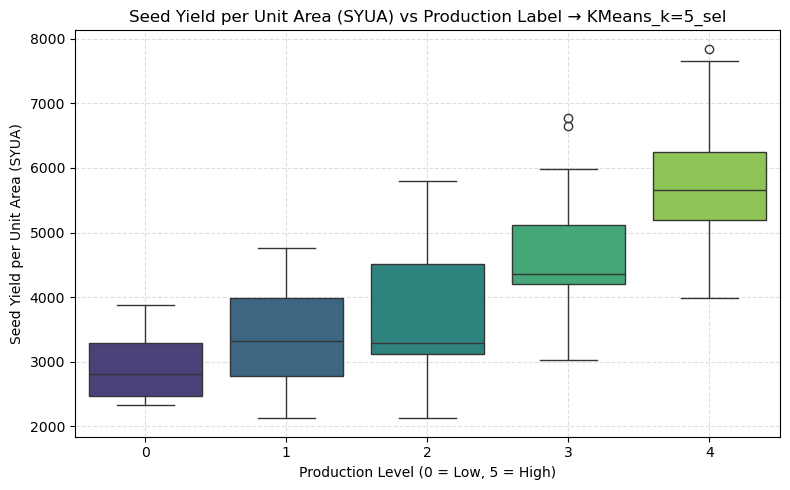

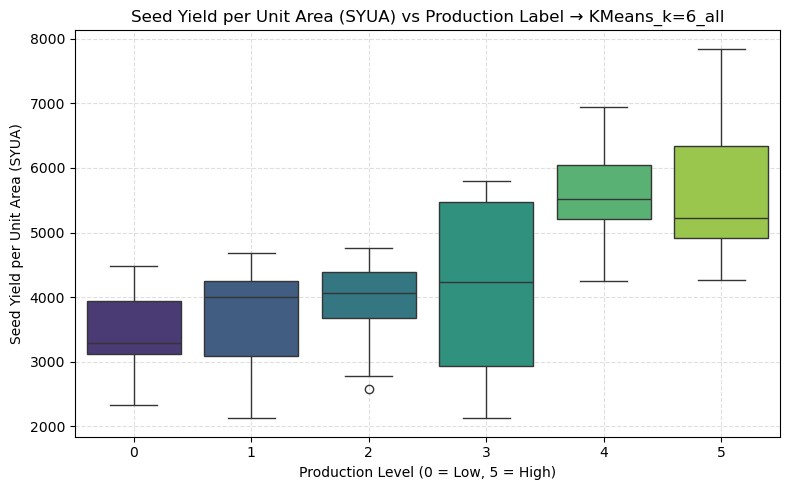

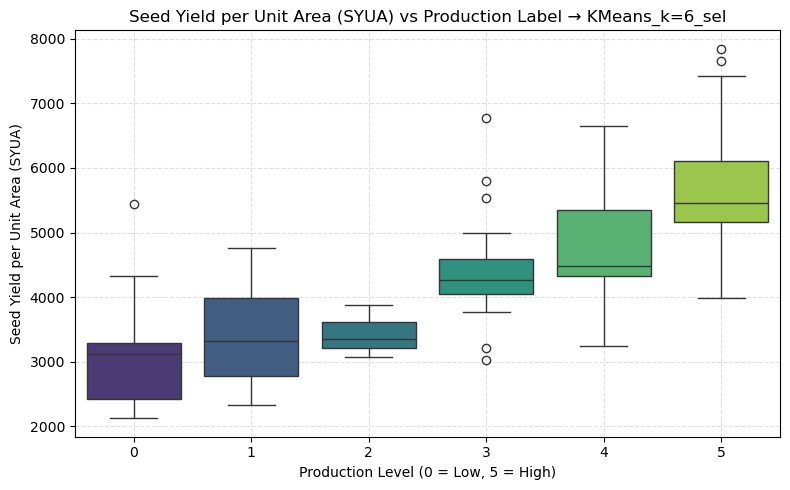

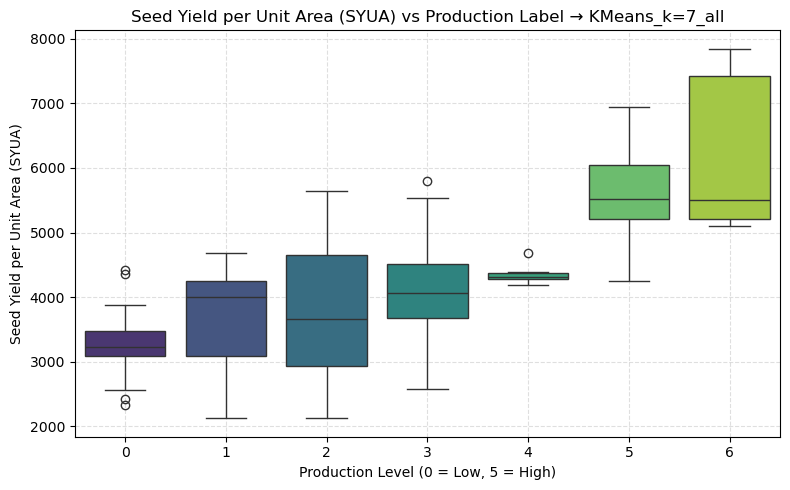

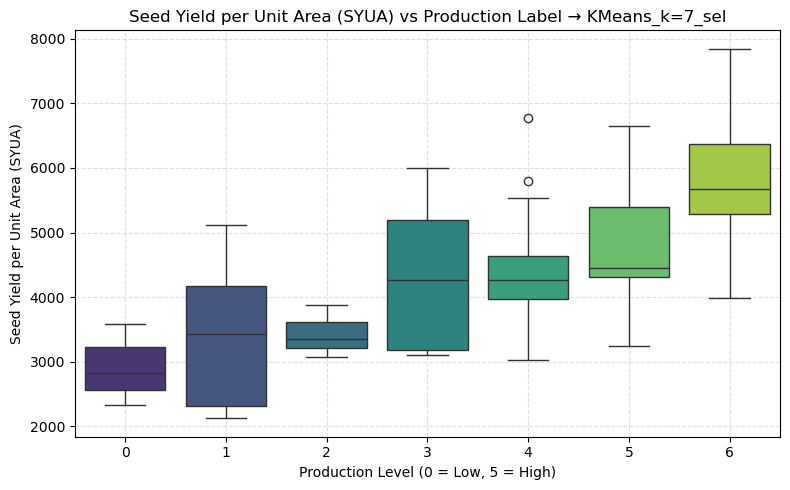

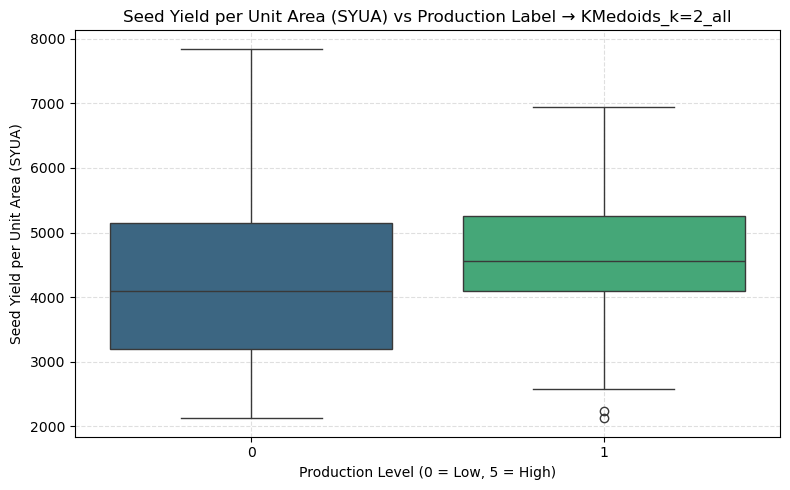

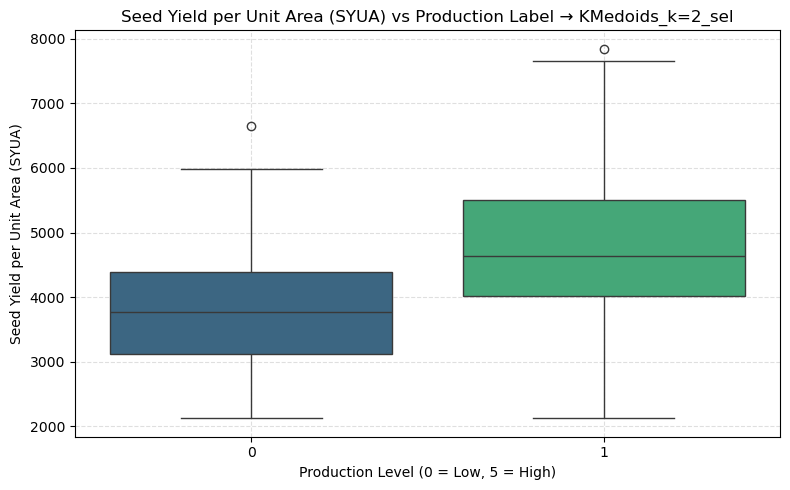

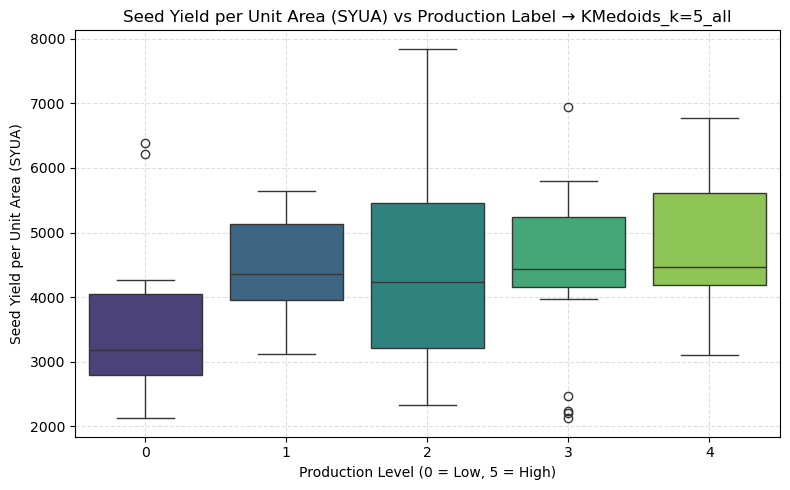

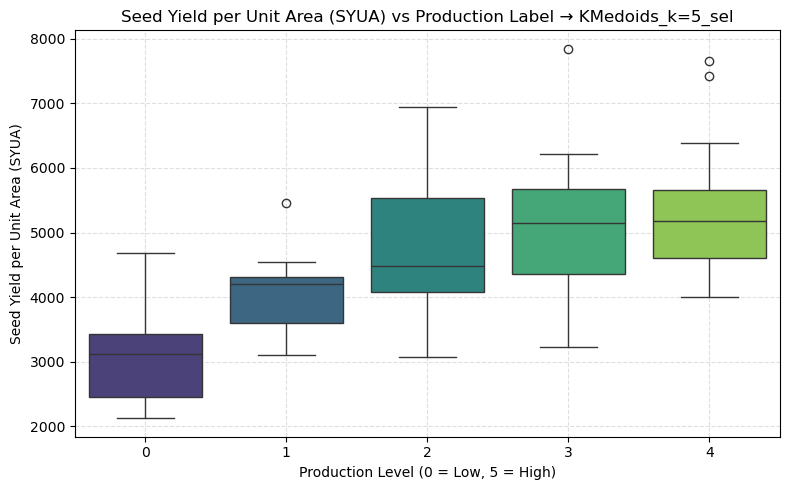

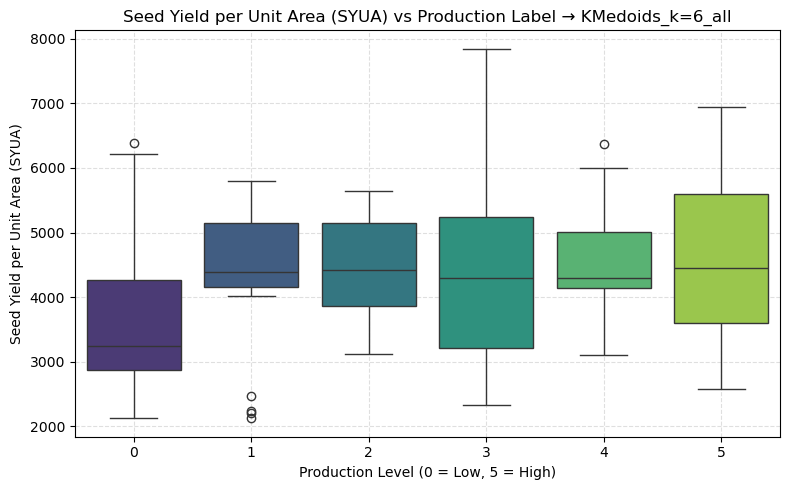

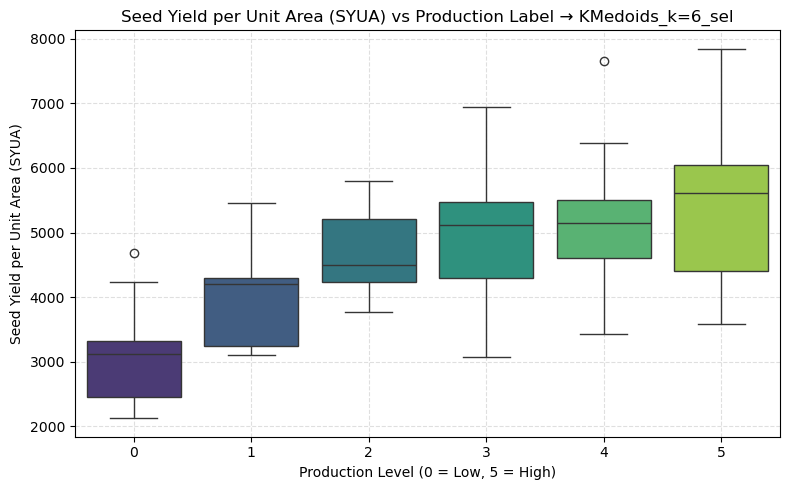

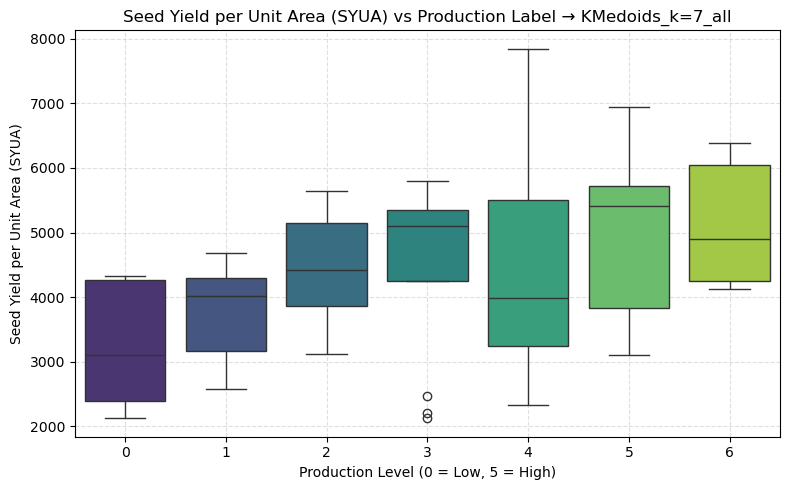

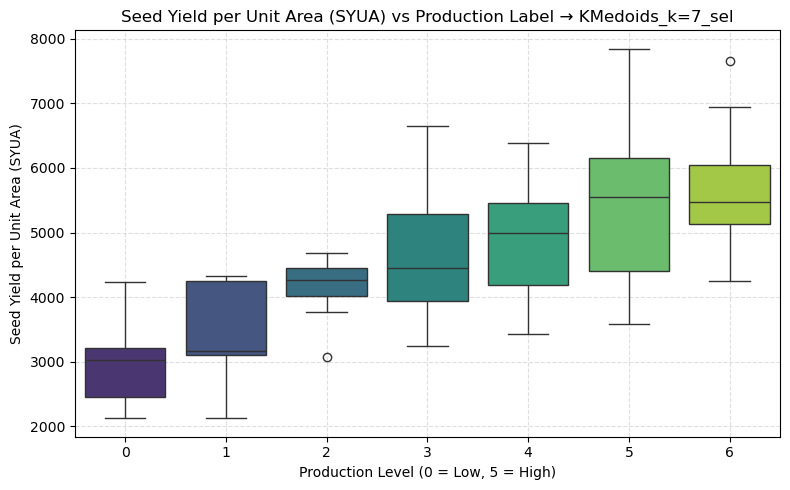

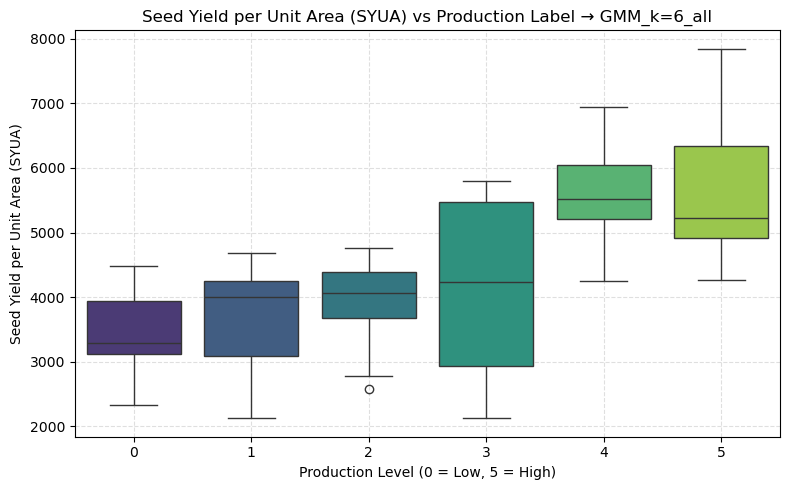

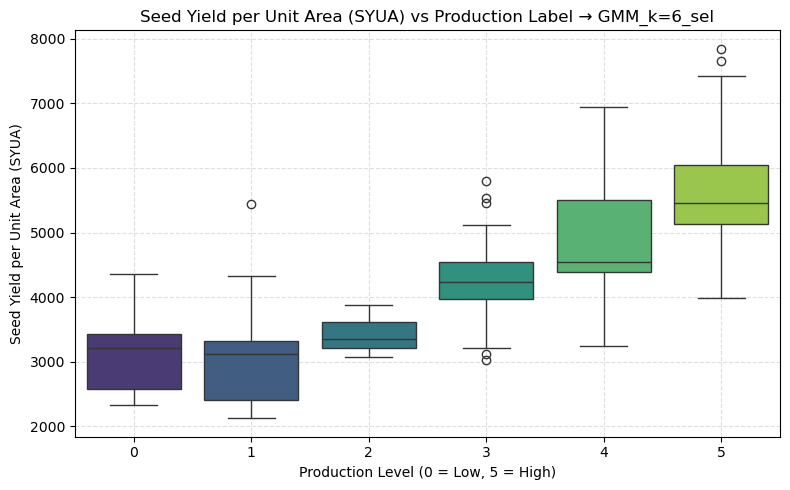

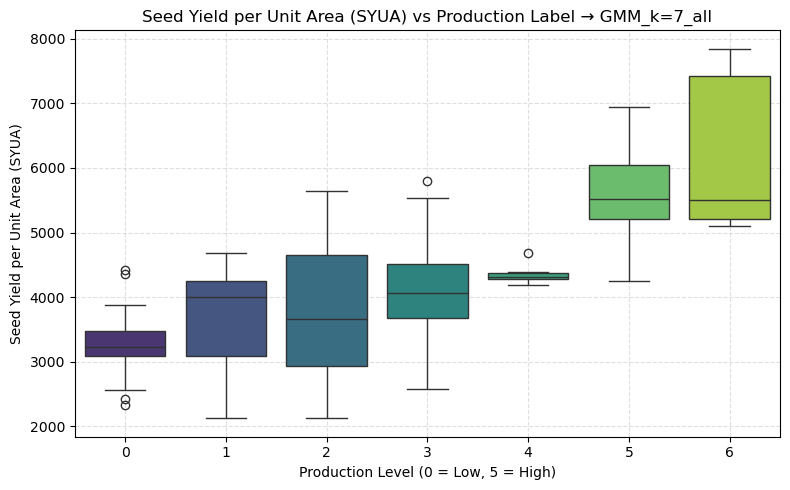

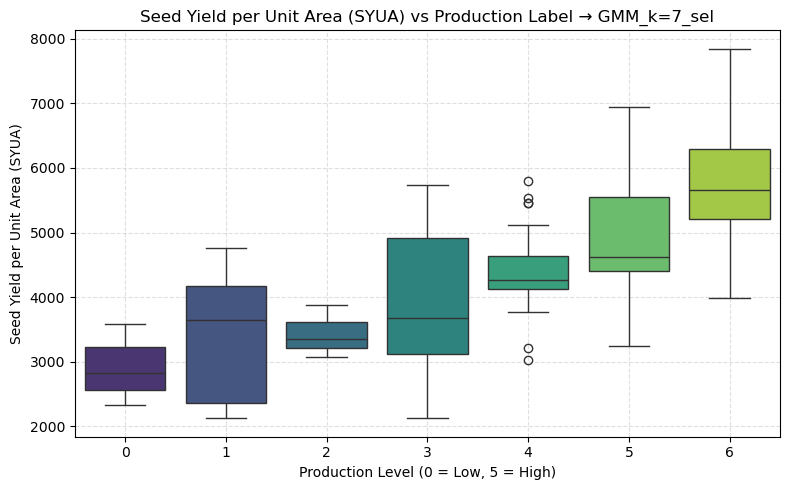

In [14]:
for feature in ["Seed Yield per Unit Area (SYUA)"]:
    for name, df_labeled, label_col in labeled_frames:
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df_labeled, x=label_col, y=feature, palette="viridis")
        plt.title(f"{feature} vs Production Label → {name}")
        plt.xlabel("Production Level (0 = Low, 5 = High)")
        plt.ylabel(f"{feature}")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()


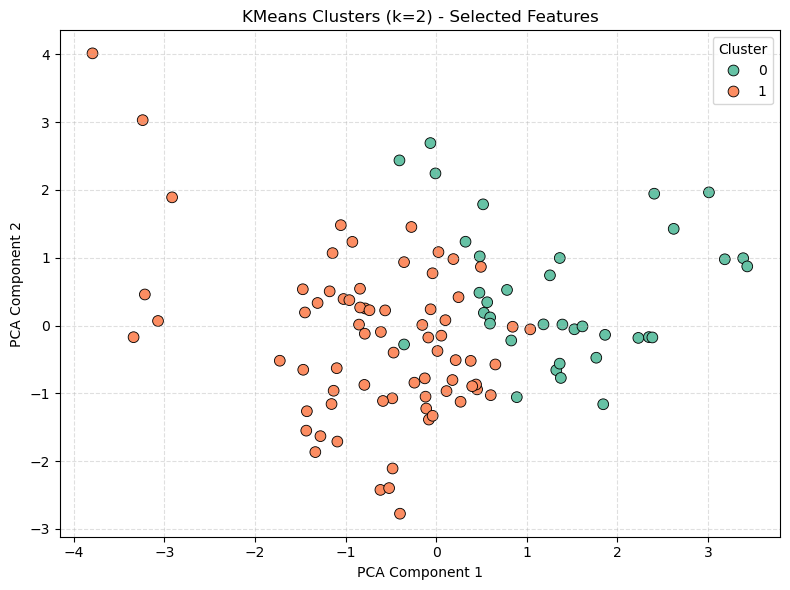

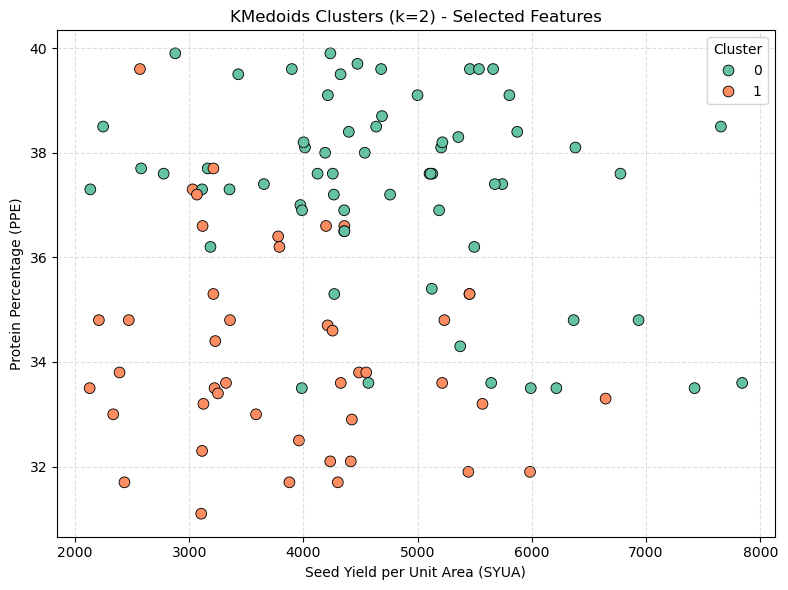

In [33]:
# %% [markdown]
# # 9. 📊 Scatter Plot Visualization of Clusters (KMeans & KMedoids with k=2, selected features only)

# %%
from sklearn.decomposition import PCA

# Prepare scaled selected feature data
X_sel_scaled_df = pd.DataFrame(X_sel_scaled, columns=X_selected.columns)

# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_sel_scaled_df)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_models["KMeans_k=2_sel"], palette="Set2", s=60, edgecolor="black")
plt.title(f"KMeans Clusters (k=2) - Selected Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["Seed Yield per Unit Area (SYUA)"], y=df["Protein Percentage (PPE)"], hue=cluster_models["KMedoids_k=2_sel"], palette="Set2", s=60, edgecolor="black")
plt.title(f"KMedoids Clusters (k=2) - Selected Features")
plt.xlabel("Seed Yield per Unit Area (SYUA)")
plt.ylabel("Protein Percentage (PPE)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()